# EDA for stores
Deeper dive than done in `src/eda/eda_main`

In [ ]:
from config import proj
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import pyspark.sql.functions as sf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
stores = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("stores.parquet")))
stores.show(5)

+---------+-------------+--------------------+----+-------+
|store_nbr|         city|               state|type|cluster|
+---------+-------------+--------------------+----+-------+
|        1|        Quito|           Pichincha|   D|     13|
|        2|        Quito|           Pichincha|   D|     13|
|        3|        Quito|           Pichincha|   D|      8|
|        4|        Quito|           Pichincha|   D|      9|
|        5|Santo Domingo|Santo Domingo de ...|   D|      4|
+---------+-------------+--------------------+----+-------+
only showing top 5 rows



### Store association with cluster, state, etc

#### Type-Cluster

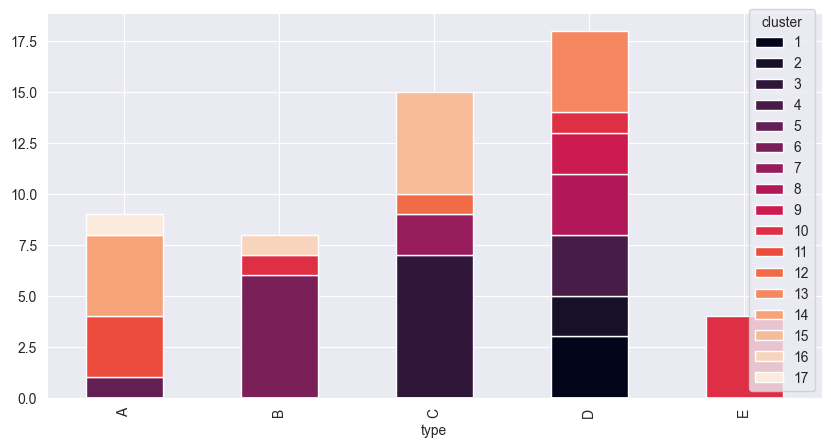

In [3]:
# Small enough to deal with pandas
stores_pd = stores.toPandas()

# Create dataset for stacked plot
store_cluster_type = stores_pd.groupby(["type", "cluster"]).size()
store_cluster_type = store_cluster_type.unstack()

# Get cols and rearrange so they show nicely on plot
cols = list(store_cluster_type.columns.values)
cols.sort(key=int)

# plot
store_cluster_type[cols].plot(kind="bar", stacked=True, figsize=(10,5), colormap="rocket")
plt.show()

In [4]:
stores_pd.groupby(["type", "cluster"]).size()

type  cluster
A     11         3
      14         4
      17         1
      5          1
B     10         1
      16         1
      6          6
C     12         1
      15         5
      3          7
      7          2
D     1          3
      10         1
      13         4
      2          2
      4          3
      8          3
      9          2
E     10         4
dtype: int64

In [5]:
stores_pd.groupby(["cluster", "type"]).size()

cluster  type
1        D       3
10       B       1
         D       1
         E       4
11       A       3
12       C       1
13       D       4
14       A       4
15       C       5
16       B       1
17       A       1
2        D       2
3        C       7
4        D       3
5        A       1
6        B       6
7        C       2
8        D       3
9        D       2
dtype: int64

- E type is a single cluster
- D is the only one to contain cluster 1
- There is no overlap with the clusters except for cluster 10, which has B, D and E

#### State-cluster

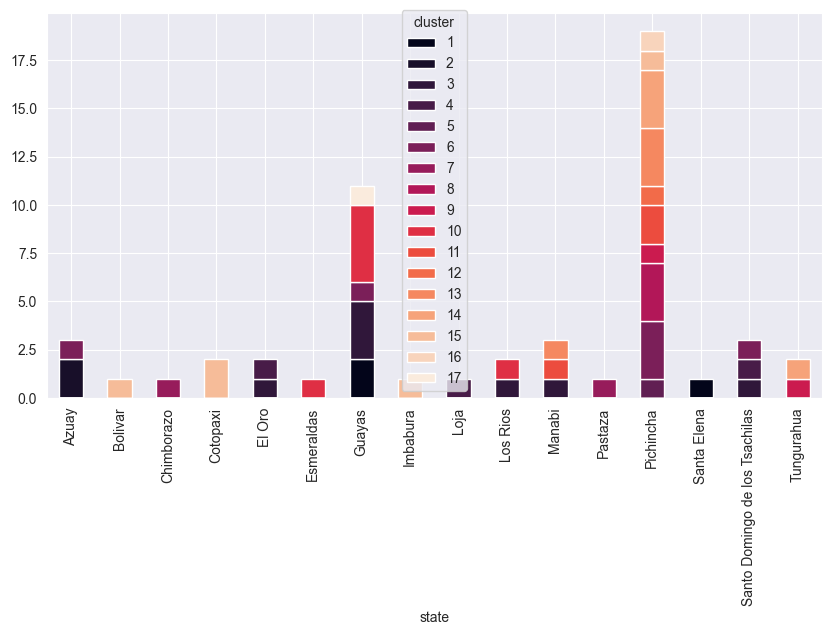

In [6]:
# Small enough to deal with pandas
stores_pd = stores.toPandas()

# Create dataset for stacked plot
store_cluster_type = stores_pd.groupby(["state", "cluster"]).size()
store_cluster_type = store_cluster_type.unstack()

# Get cols and rearrange so they show nicely on plot
cols = list(store_cluster_type.columns.values)
cols.sort(key=int)

# plot
store_cluster_type[cols].plot(kind="bar", stacked=True, figsize=(10,5), colormap="rocket")
plt.show()

Multiple clusters in each state, therefore clusters aren't necessarily built from state information. They could be more to do with regional/city or affluence properties.

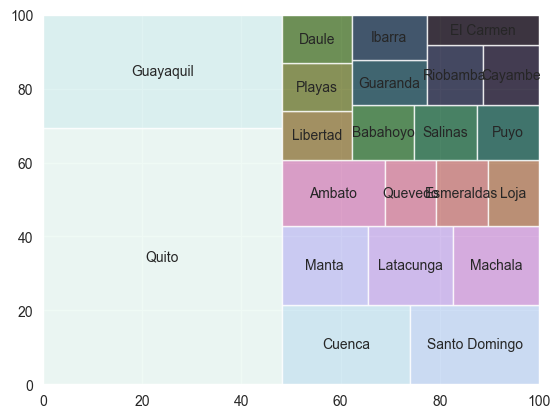

In [7]:
store_city = stores_pd.city.value_counts()
squarify.plot(sizes=store_city, label=store_city.index, alpha=.8, color=sns.color_palette('cubehelix_r', 22))
plt.show()

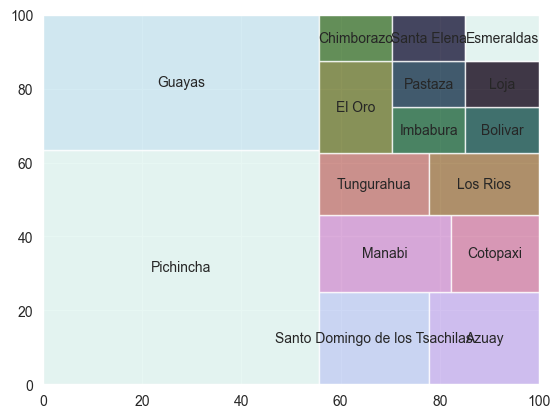

In [8]:
store_state = stores_pd.state.value_counts()
squarify.plot(sizes=store_state, label=store_state.index, alpha=.8, color=sns.color_palette('cubehelix_r', 15))
plt.show()

In [9]:
stores_pd[["state", "city"]].drop_duplicates().sort_values(by="state")

,state,city
36,Azuay,Cuenca
18,Bolivar,Guaranda
13,Chimborazo,Riobamba
11,Cotopaxi,Latacunga
39,El Oro,Machala
42,Esmeraldas,Esmeraldas
34,Guayas,Playas
35,Guayas,Libertad
23,Guayas,Guayaquil
26,Guayas,Daule


Pichincha has a lot of stores, mostly due to Quito having so many

### Store open/close dates

In [10]:
transactions = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("transactions.parquet")))
txn = transactions.toPandas()

In [11]:
max_min_dates = txn.groupby(['store_nbr']).agg({'date':[min , max]}).reset_index()
pd.DatetimeIndex(max_min_dates.date["min"]).year.value_counts()

2013    47
2015     5
2017     1
2014     1
Name: min, dtype: int64

Most stores open from the start of transactions

### Top selling stores

In [13]:
# Load feature store
pfs = spark.read.parquet(str(proj.Config.paths.get("data_proc").joinpath("feature_store.parquet")))

In [15]:
# Roll up by total daily sales, then find the average daily sales across all stores and dates
avg_daily_sales = pfs\
    .groupby("store_nbr", "city", "state", "date")\
    .agg(sf.sum("unit_sales").alias("daily_sales"))\
    .groupby("store_nbr", "city", "state")\
    .agg(sf.sum("daily_sales").alias("avg_daily_sales"))

In [19]:
# Top 10 stores
avg_daily_sales.toPandas().sort_values("avg_daily_sales", ascending=False).round(0)

,store_nbr,city,state,avg_daily_sales
42,44,Quito,Pichincha,33221733.0
14,45,Quito,Pichincha,29626813.0
22,3,Quito,Pichincha,27715684.0
2,47,Quito,Pichincha,27638632.0
13,49,Quito,Pichincha,25908695.0
36,46,Quito,Pichincha,21657216.0
29,48,Quito,Pichincha,18489419.0
48,51,Guayaquil,Guayas,17186302.0
3,8,Quito,Pichincha,16601476.0
33,7,Quito,Pichincha,15134646.0


Top stores are all from the same city, Quito.

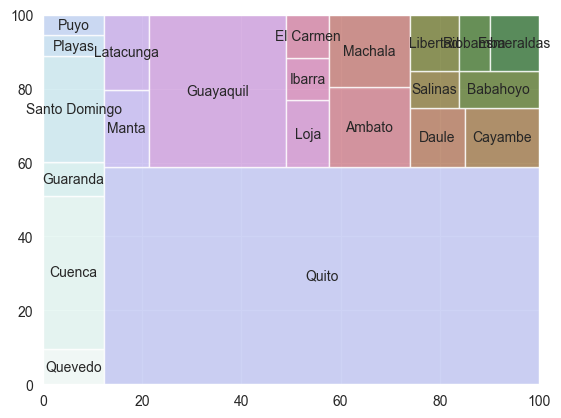

In [21]:
avg_daily_sales = pfs\
    .groupby("city", "date")\
    .agg(sf.sum("unit_sales").alias("daily_sales"))\
    .groupby("city")\
    .agg(sf.sum("daily_sales").alias("avg_daily_sales"))\
    .toPandas()

# Visualisation of cities by average daily unit sales
squarify.plot(sizes=avg_daily_sales["avg_daily_sales"],
              label=avg_daily_sales["city"],
              alpha=.8,
              color=sns.color_palette('cubehelix_r', 33),
              text_kwargs={'fontsize':10})
plt.show()

Plot above is clear, Quito is almost half of all unit sales.